# Homework 4
# Costa Rica Poverty Classification

## Purpose: 
In this notebook, I am going to go through the pre-processing steps required to prepare this data for a model. This includes both imputing missing values, and creating new features that can help the prediction process. Then I will put the data through several models and select several to tune to get a better score. Then I will focus on different applications for the model. I will explore how changing certain parameters can help a model focus on increasing the recall of certain classes. I will discuss different metrics to measure a model by and how different types of models can help ensure that we are answering the questions we want to answer with our data.

### Credit:
Data : [Kaggle - Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction)

## Table of Contents
1. [Read in Data](#read)  
2. [Clean Data](#clean)  
    2.1 [Understanding Missing Values](#misviz)  
    2.2 [Impute Missing Values](#impute)  
    2.3 [Categorical Variables](#catvar)  
3. [Feature Engineering](#feat)  
4. [Visualization and Exploration](#viz)  
    4.1 [Target Variable](#viztarget)  
    4.2 [Predictor Variables](#vizvars)  
5. [Modeling](#model)  
    5.1 [Cross-Validation Scores](#crossval)  
    5.2 [Random Search](#rand)  
    5.3 [Classification Reports & Confusion Matrices](#cm)  
6. [Handling Unbalanced Data](#imbdata)  
    6.1 [Random Forest with Weights](#weights)  
    6.2 [Oversampling](#smote)  
7. [Understanding & Interpreting the Model](#featimport)
8. [Conclusion](#done)

In [1]:
#Basic Data Manipulation
import pandas as pd
import numpy as np

#Graphing and Color Settings
import seaborn as sns
sns.set_palette(sns.color_palette('hls', 7))
import matplotlib.pyplot as plt
%matplotlib inline

#Silence Deprication Warnings
import warnings
warnings.filterwarnings("ignore")

#Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#Validation
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix

#Undersampling
from imblearn.over_sampling import RandomOverSampler

## 1. Read in Data
<a id="read"></a>
First, we are going to read in our training data and our test data and make sure we mark our target variable (Poverty Level). We are setting apart our target variable as just the poverty level of the head of households since that is what we are going to try to predict.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train.loc[(train['parentesco1']==1), 'Target']
Id = test.Id

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [4]:
pd.options.display.max_columns = 150
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Looking at the info of our training data, it looks like we have a lot of variables that are integers. Scrolling through all of our variables, we can see that a lot of these are binary variables. We also have a few floats that include a few squared variables among other things. We also have 5 categorical variables that we are going to have to change before we put our data into a model. 

Now we are going to combine our train and test data into one data frame to clean it.

In [5]:
ntrain = train.shape[0]
data = pd.concat((train.drop('Target', axis = 1), test)).reset_index(drop = True)
data = data.drop('Id', axis = 1)

In [6]:
data.shape

(33413, 141)

## 2. Clean Data
<a id="clean"></a>
First, we need to explore our data a little bit and see what needs to be cleaned. We already know that we have 5 categorical variables that we are going to have to change. We also need to find out if there are any missing values we need to impute or if there is anything else we need to do to prepare our data for modeling. 

## 2.1 Understand Missing Values
<a id="misviz"></a>
To better understand the data we have to work with, we are going to graph what percent of each variable is composed of missing values. Then we are going to take a look at the [data descriptions](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data) to better understand why there might be missing values and how we can most accurately impute them.

Text(0.5, 1.0, 'Percent missing data by feature')

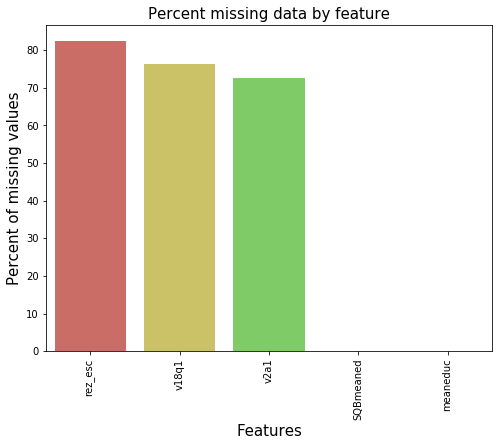

In [7]:
#Check to see missing values
#data.isna().sum().sort_values(ascending = False)[:35]
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y = data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

It looks like we only have 5 features with missing values. These features are found in the data description mentioned above. Below is the description of each feature and some thoughts on how we might impute them.

**rez_esc** - Years behind in school:
The Kaggle Discussions give us some insights that this is only defined for children in school. Thus we will assume anyone ages 18+ should not have a value here.

**v18q1** - Number of tablets household owns:
This value is missing if the number of tablets owned by the household is equal to zero. So we will replace all of these missing values with zero.

**v2a1** - Monthly rent payment:
There is no clear answer to why these are missing. We will have to look at the data to see if we can find something.

**SQBmeaned** - Square of the mean years of education of adults (>=18) in the household

**meaneduc** - Average years of education for adults (18+):

We see for both of these education related values we are missing the same number of values. So for these, we will explore the data and see if there is some other variable that explains these.

## 2.2 Impute Missing Values
<a id="impute"></a>
Now, that we know what features have missing values, we can begin to fill them in correctly. First, we are going to fill in the one that we know how to do. Any house that has a missing value for number of tablets, does not have any tablets, so we will fill all of those in with 0.

In [8]:
# The easy one. Number of tablets
data.v18q1 = data.v18q1.fillna(0)

Now let's look into the missing rent values. There is no obvious reason given in the data description as to why these values might be missing. We can however, look through the data and see if there are any other variables that might be related to rent payments. When we look through these, we find that home ownership is included in several of the variables. We are going to look at the distribution of the missing values among the different types of home ownership.

In [9]:
#Create new dataset with the count of missing values and the types of ownership
ownership = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']
ownership_data = data.loc[data['v2a1'].isnull(), ownership].sum()
ownership_data = ownership_data.reset_index()

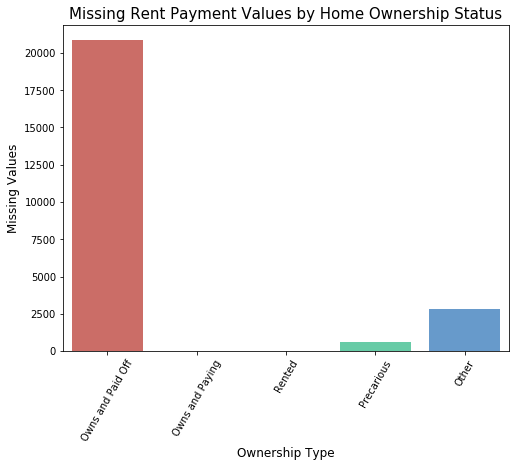

In [10]:
f, ax = plt.subplots(figsize=(8, 6))
plot = sns.barplot(x = 'index', y = 0 , data = ownership_data)
plt.xlabel('Ownership Type', fontsize=12)
plt.ylabel('Missing Values', fontsize=12)
plt.title('Missing Rent Payment Values by Home Ownership Status', fontsize=15)
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.show()

Well that tells us a lot. From our graph we can see that a majority of the people missing rent payments own a house and have paid it off. No wonder they don't have rent payments. They have nothing to pay off. The rest of the missing values still remain a mystery however. For everyone that owns a house that they have paid off, we are going to put their rent payment as 0.

For the rest of these values we have a few options. We could keep exploring these missing values and see if there is any other hints in the data as to what they should be. Instead, we are going to fill in all of these with the median value of the data set. We are also going to create a new variable and flag which families are missing a rent value. Sometimes our model can learn just as much from those who don't have values as from those who do.

In [11]:
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

#Flag any missing observations we don't understand
data['missing_rent'] = 0
data.loc[(data.tipovivi1.isnull()), 'missing_rent'] = 1

#Fill in remaining missing values with median only using training data from head of households
data['v2a1'] = data.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

We now have 2 of our features filled in. Let's look at our education related features now. Since we don't have any information about why these values are missing, and I don't see any obvious related variables in the data descriptions, we will just look at all of the rows that have missing values and see if there is anything obvious in the data.

In [12]:
data.loc[(data['SQBmeaned'].isnull()) & (data['meaneduc'].isnull())]

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,missing_rent
1291,0.0,0,7,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,10,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1b31fd159,1,0,0,1,8,no,10,NaN,0,0,0,1,0,0,0,0,0,5,0.200000,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,18,100,324,1,0,1,0.040000,64.0,NaN,324,0
1840,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,6,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,0,1,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.000000,64.0,NaN,324,0
1841,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,4,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,1,0,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.000000,64.0,NaN,324,0
2049,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,faaebf71a,2,0,0,2,8,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361,0
2050,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,faaebf71a,2,0,0,2,8,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361,0
9561,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.500000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.250000,64.0,NaN,324,0
10092,399378.0,0,6,0,1,0,1,3.0,0,0,0,0,1,1,0,1,1,1,4,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,bb7038e41,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,4,1.000000,0,0,1,0,0,0,1,1,4,1,0,0,0,0,0,1,0,18,121,324,1,0,1,1.000000,64.0,NaN,324,0
10093,180000.0,0,4,0,1,1,0,0.0,0,0,0,0,2,2,0,2,2,2,2,12,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,4937daf94,2,0,0,2,8,no,12,NaN,0,0,0,0,0,0,0,1,

There doesnt seem to be anything obvious about why these values are missing, so we are going to impute them. We will do this by grouping by years of schooling and filling missing values with the median. This seems reasonable since the years of schooling of a single person and the mean years of schooling in their household have some relationship.

After imputing the mean education, we will just square that variable to fill in the squared mean education.

In [13]:
data['meaneduc'] = data.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))
data['SQBmeaned'] = (data.meaneduc)**2

The last variable we need to fill in is the years behind in schooling. Since we know that this is only going to apply for kids between the age of 7 & 18, we will fill in a 0 for everyone that is not in that age group. After filling in those, we will impute the rest of the values using the median of the training data based on the age of the kids.

Once again, we are going to mark those that have missing values with a binary flag to see if that gives our model any extra information.

In [14]:
#We assume anyone not between the age of 7 and 17 is not in school and thus this doesnt apply to them.
data.loc[((data['age'] >= 18) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

#For those in school we flag them as missing values.
data['missing_rez_esc'] = 0
data.loc[(data.rez_esc.isnull()), 'missing_rez_esc'] = 1

#Now we are going to impute the rest of our missing values after grouping them by age and years in school
#This should give us a good idea of if they should be years behind.
data['rez_esc'] = data.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))

## 2.3 Categorical Variables
<a id="catvar"></a>
Now all that we have left to clean are the categorical variables. We already removed the Id variable since it gives us no information, and now we should be left with 4 more categorical variables. Let's see what they are and decide what to do with them.

In [15]:
data.select_dtypes(include = 'object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


The idhogar variable is a family identifier that we are going to drop before we begin modeling, so we will leave it alone for now. When we look at the other 3 variables, it looks like they are all a mix of yes, no, and integers. If we look at the documentation of the features, it tells us that no = 0, and yes = 1. So we can go ahead and replace the text data in these columns accordingly.

In [16]:
cat_cols = ['dependency', 'edjefe', 'edjefa']
for col in cat_cols:
    data.loc[(data[col] == 'yes'), col]=1
    data.loc[(data[col] == 'no'), col]=0
data[cat_cols] = data[cat_cols].apply(pd.to_numeric)

## 3. Feature Engineering
<a id="feat"></a>
Feature engineering is extremely important to helping your model perform as well as possible. The difficult part is knowing what variables are going to add value to a model.   

I am going to go ahead and create 4 new variables. After running all of the data through our models, we will be able to see which of these variables actually contributed to the model.

I am going to create 2 new variables based on the makeup of each household. We are going to get a value for what percentage of each household is made up of children and what percentage is made up of elderly people.  

The other two variables we will create will have to do with the quality of living conditions for each family. The first one will be a technology score. We will give a family 1 point for each piece of technology that they have in their home.   

The other variable will be home quality. We will look at the walls, floors, etc. and assign them either 0, 1, or 2 points based on the quality of each part of the home.  

Hopefully with these four variables we will be able to build a pretty good model.

In [17]:
data['child_per'] = data['hogar_nin'] / data['hogar_total']
data['old_per'] = data['hogar_mayor'] / data['hogar_total']
data['tech_score'] = (data['v18q'] + data['abastaguadentro'] + data['public'] + data['planpri'] + data['coopele']
                      + data['energcocinar2'] + data['energcocinar3'] + data['computer'] + data['mobilephone']
                      + data['television'])
data['home_quality'] = (data['cielorazo'] + data['epared2'] + 2*data['epared3'] + data['etecho2'] + 2*data['etecho3']
                        + data['eviv2'] + 2*data['eviv3'])

## 4. Visualizations
<a id="viz"></a>
The data has been cleaned and we have added a few more features to prepare it for a model. Now before we actually begin modeling the data, we want to understand a little bit better both our target variable and our features. To visualize them, we are going to look at only the heads of household in our training data. All of the visualizations I will do will be done using the [seaborn package](https://seaborn.pydata.org/).

In [18]:
train = data[:ntrain]
x = train.loc[train['parentesco1']==1].drop('idhogar', axis = 1)
train = pd.concat([x, y], axis = 1)
test = data[ntrain:].drop('idhogar', axis = 1)
train.shape

(2973, 147)

## 4.1 Target Variable
<a id="viztarget"></a>
Before we begin modeling we need to understand our target variable. In this situation, our target variable is the poverty level of a family. To get a feel for our target variable, we are going to look at the features that are most correlated with the poverty level. Then we will look at the distribution of the poverty levels.

Text(0.5, 1.0, 'Variables Correlated With Poverty Level')

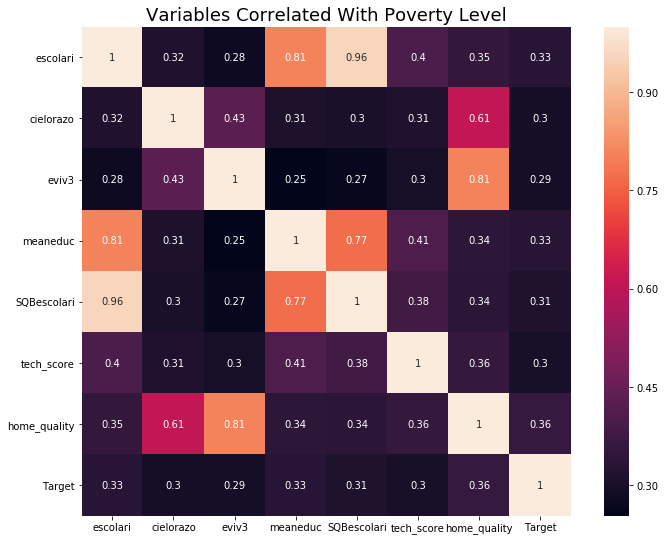

In [19]:
#Take a look at the variables that are most highly correlated with Poverty Score
corr_train = train.corr()
highest_corr = corr_train.index[abs(corr_train["Target"])>0.29]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Poverty Level', fontsize=18)

So in this heatmap, we are only seeing the variables with the highest correlation with poverty levels. The highest correlation we have with poverty comes from the home quality variable we created with a correlation of .36. This is probably a lot of what we would expect to predict poverty. People with more education will tend to have lower poverty levels. Now we are going to look at the distribution of the poverty levels and then we will look at some of the more important features for our model.

([<matplotlib.axis.XTick at 0x2a9ee119b70>,
 <a list of 4 Text xticklabel objects>)

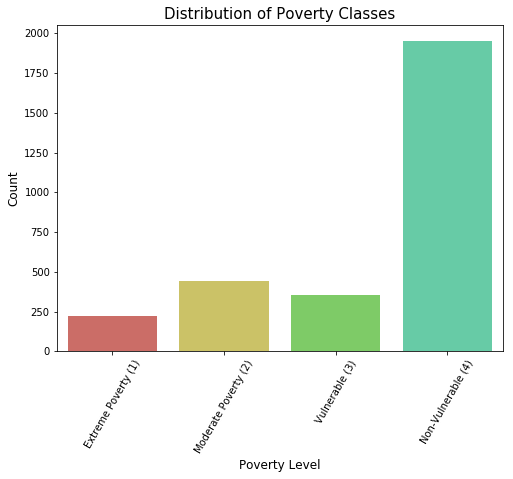

In [20]:
#See the distribution of poverty scores
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(train.Target)
plt.title('Distribution of Poverty Classes', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

The distribution of poverty levels is far from even. From a moral perspective, this is a great thing. It is nice to see a lot more people out of poverty than in it. However, for our model, this may not be ideal. Further on in our notebook we will look at ways to deal with this inbalanced data.

## 4.2 Predictor Variables
<a id="vizvars"></a>
Now we are going to take a look at some of the variables that were highly correlated with our target variable and see what they can tell us about poverty.

Text(0, 0.5, 'Average Poverty Level')

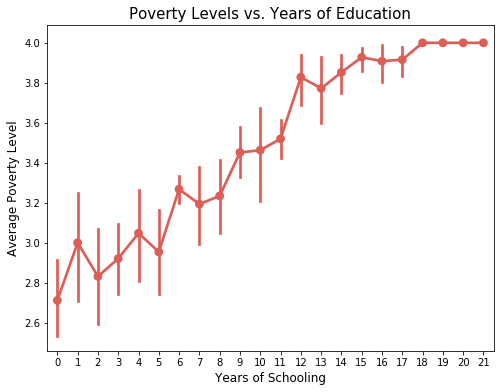

In [21]:
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['escolari'], y = train.Target)
plt.title('Poverty Levels vs. Years of Education', fontsize=15)
plt.xlabel('Years of Schooling', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

First, we look at the years of schooling plotted against poverty levels. Since 4 is considered as non-vulnerable, we see that poverty decreases as schooling increases. This intuitively makes a lot of sense.

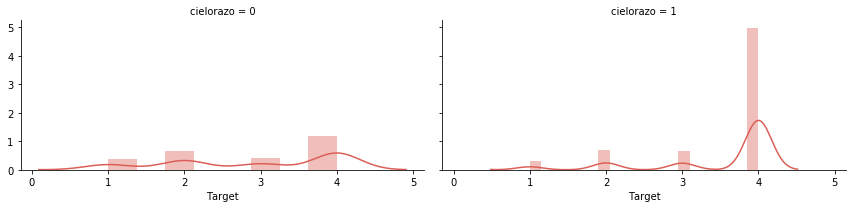

In [22]:
plot = sns.FacetGrid(data = train, col ='cielorazo', aspect=2, margin_titles = True)
plot.map(sns.distplot, 'Target')

Here we are looking at the distributions of poverty levels for families whose homes have a roof (denoted as cielorazo = 1) vs. families who do not have a roof. We can see that families with a roof are generally a lot better off than those without a roof.

Text(0, 0.5, 'Average Household Education')

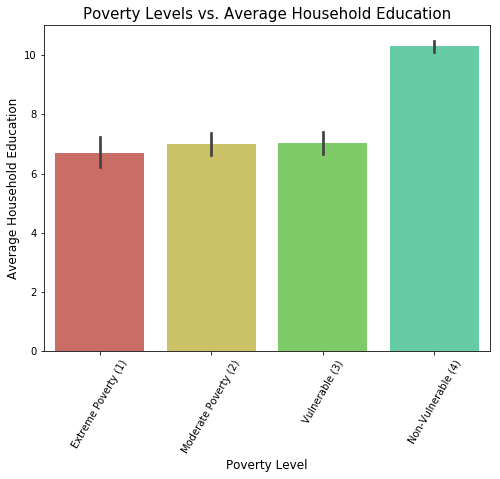

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'Target', y = 'meaneduc', data = train)
plt.title('Poverty Levels vs. Average Household Education', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)
plt.ylabel('Average Household Education', fontsize=12)

Now if we look at the average education in a household, there is not much of a difference between families in extreme poverty, families in moderate poverty, and vulnerable families. We do see however, that families that are not vulnerable generally have a much higher mean education in their household.

Text(0, 0.5, 'Average Poverty Level')

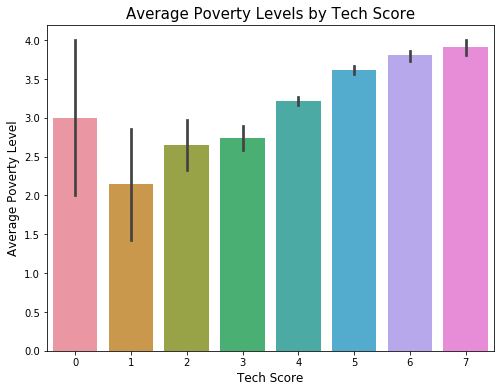

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'tech_score', y = 'Target', data = train)
plt.title('Average Poverty Levels by Tech Score', fontsize=15)
plt.xlabel('Tech Score', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

The technology score is a variable that we created. We see that for the most part we see what we expect to see. As families have more technology, they are generally more wealthy. There is the very first bar that sticks out as somewhat strange however. It looks like families with a technology score of 0 have a wide range of poverty levels. This could be due to many different things. Data collection could have been performed poorly or there may just be families that choose to live without technology. Either way, because most of the data looks like a good predictor, we are going to leave it.

Text(0, 0.5, 'Average Poverty Level')

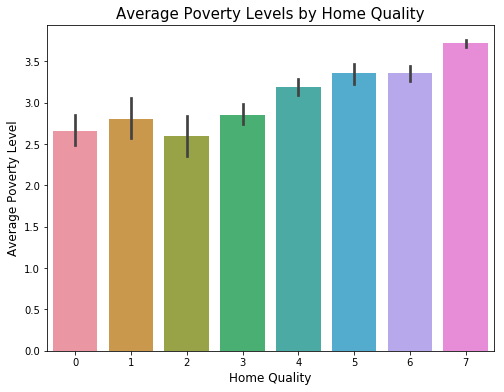

In [25]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'home_quality', y = 'Target', data = train)
plt.title('Average Poverty Levels by Home Quality', fontsize=15)
plt.xlabel('Home Quality', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

Lastly, we come to the other variable we created of home quality. It seems once again that we get what we expected. As home quality increases, the poverty levels decrease.

## 5. Modeling
<a id="model"></a>
It is time to build our models. We are going to split our data into a train and a test set and define a function to compute the cross validation f1-macro score of our models. The f1-macro score is computed by taking the f1 score and weighting each class equally to compute an average f1 score. We are going to look at a few different models and see which ones perform the best with this kind of problem.  

[Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): This is an ensemble model that uses a bagging technique on decision trees to create a more powerful classifier.  

[LightGB](https://lightgbm.readthedocs.io/en/latest/Python-API.html): This model uses gradient boosting to combine a lot of weak learners(decision trees) into a more powerful classifier.  

[K Nearest Neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): K Nearest Neighbors uses a distance metric (usually euclidean) to make predictions based on the classes of the nearest observations of the value being predicted.  

[Support Vector Classification](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): This is a classifier that with multi-class problems uses a one-to-one scheme.  

[Gaussian Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html): This model implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian and the parameters are estimated using maximum likelihood.

In [26]:
#Get a split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [27]:
def test_clf(clf):
    score = cross_val_score(clf, x, y, scoring = 'f1_macro', cv = 5)
    print(clf.__class__.__name__,"Score =", score.mean())

## 5.1 Cross-Validation Scores
<a id="crossval"></a>
For each model we are going to find the f1-macro score using cross validation with 5 folds. This will give us an idea of which models will perform the best after tuning.

In [28]:
rf = RandomForestClassifier()
lgb = LGBMClassifier()
knn = KNeighborsClassifier()
svc = SVC()
gnb = GaussianNB()

models = [rf, lgb, knn, svc, gnb]
for clf in models:
    test_clf(clf)

RandomForestClassifier Score = 0.35749637813683083
LGBMClassifier Score = 0.266994226778726
KNeighborsClassifier Score = 0.31170305441515656
SVC Score = 0.19963169842530937
GaussianNB Score = 0.35256980756141637


Of these models, the Random Forest and the Gaussian Naive Bayes performed the best. The GaussianNB does not have many parameters to tune. So we are going to leave it as is. For the Random Forest model, we are going to use a random search to find the best parameters.

## 5.2 Random Search
<a id="rand"></a>
To set up our random search, we need to set up the parameters we want to search through. You can find the parameters of the model in the documentation linked in the model description above. We will tune these parameters, get a new f1-macro score, and print out the best parameters for our model to use.

In [29]:
#A little hyperparameter tuning
params = {'rf' : {'n_estimators' : np.arange(100,2000,100),
                  'criterion' : ['gini', 'entropy'],
                  'min_samples_split' : np.arange(2, 5, 1),
                  'max_features' : np.arange(10, 50, 10),
                  'max_depth' : np.arange(3, 10, 1)}
         }

In [38]:
def tune_params(clf, params):
    clf_rs = RandomizedSearchCV(clf, param_distributions = params, n_iter = 20, scoring = 'f1_macro', verbose=1)
    clf_rs.fit(x_resampled, y_resampled)
    clf_rs_pred = clf_rs.predict(x_test)
    score = f1_score(y_test, clf_rs_pred, average = 'macro')
    print('F1 Score: %s \n' %(score))
    print('Best Parameters:',clf_rs.best_params_)

In [135]:
rf = tune_params(rf, params['rf'])

F1 Score: 0.38225804658668106 

Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'max_features': 30, 'max_depth': 9, 'criterion': 'entropy'}


In [31]:
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 4, max_features = 30, max_depth = 9, criterion = 'entropy')

It looks like our models improvements were decent. With this data it looks like the best f-1 macro score we can get is about .38.

## 5.3 Classification Reports & Confusion Matrices
<a id="cm"></a>
Right now we only know a little bit about our models. We know the f1-macro score that tells us overall a little bit about how the model is doing. But what if we want to know where our model is succeeding and failing? We can use classification reports and confusion matrices to see how our model performs with respect to each class we are trying to predict.

In [176]:
#Define function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)
    plt.yticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

In [177]:
#Train models and make predictions
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
gnb.fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)

In [179]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.50      0.09      0.15        56
           2       0.40      0.19      0.25       113
           3       0.67      0.04      0.08        96
           4       0.70      0.99      0.82       479

   micro avg       0.67      0.67      0.67       744
   macro avg       0.57      0.33      0.33       744
weighted avg       0.63      0.67      0.59       744



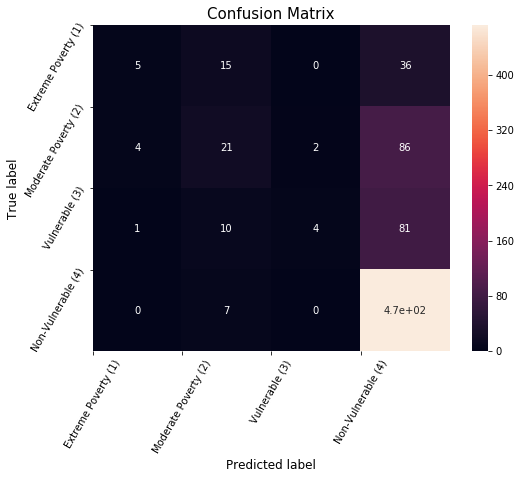

In [178]:
plot_confusion_matrix(y_test, rf_pred)

First we are looking at our Random Forest model. If we look at the classification report, we can see that our precision is decent with respect to our poorest and our richest classes, and not so great with our other two. But then if we look at recall, we are only actually capturing 10% of our poorest class in our predictions of that class. 

It seems like really what our model is doing is predicting a lot of the class that is not in poverty because most of the time it will be right since we have so many of those types of people. This is where the imbalanced classes we saw earlier come into play. Looking at our confusion matrix, we can see that for every single class, our model predicted more of them to be non-vulnerable than anything else. This may be good for our models accuracy, but in a second we will talk about some real world applications.

In [180]:
gnb_report = classification_report(y_test, gnb_pred)
print(gnb_report)

              precision    recall  f1-score   support

           1       0.27      0.36      0.31        56
           2       0.28      0.35      0.31       113
           3       0.17      0.23      0.20        96
           4       0.80      0.67      0.73       479

   micro avg       0.54      0.54      0.54       744
   macro avg       0.38      0.40      0.39       744
weighted avg       0.60      0.54      0.56       744



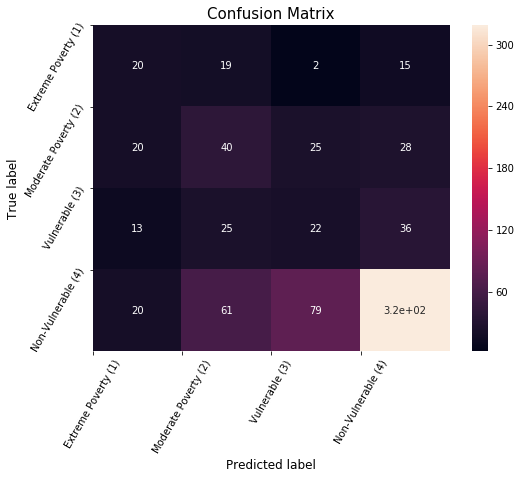

In [181]:
plot_confusion_matrix(y_test, gnb_pred)

The Gaussian Naive Bayes model, which had a nearly identical f1-macro score to our Random Forest model, distributed its predictions very differently. The precision has greatly decreased for most of the classes compared to the other model, but the recall has increased in all of the classes except for the non-vulnerable group. So with a similar score, our model is making very different predictions. But what does this all mean when interpreting and using our model?

## 6. Working with Imbalanced Data
<a id="imbdata"></a>
#### Real World Application
If we were to be using our model to help predict who was going to be receiving financial aid from our organization, we would not be interested in a model with high accuracy alone. We could achieve that by predicting nearly everyone to be out of poverty. But what good would that do us? We still wouldn't know who needed help. This is the problem with inbalanced data.  

Inbalanced data can cause our model to look for the highest accuracy by predicting whichever class has the highest count of observations. What we really need if we are going to help people in need, is to predict the people that are in poverty, even if we accidentally also predict some people to be poor who are really not. This means we are most worried about the recall of our lowest poverty levels.  

There are several ways that we can adjust our model to account for this inbalanced data. In this notebook we will explore 2 of them. We will look at adding weights to our model, and oversampling our data.

## 6.1 Weights
<a id="weights"></a>
Certain models allow us to give an input of weights by class to tell the model which classes should be weighted more heavily in the cost function during the training and prediction. We are going to give our Random Forest model a set of weights putting a lot more importance on our highest poverty level and less on our lowest.

In [182]:
weights = {1:5, 2:1, 3:1, 4:.3}
rf_weighted = RandomForestClassifier(n_estimators = 1600, min_samples_split = 4, max_features = 30, max_depth = 9,
                                     criterion = 'gini', class_weight = weights)
rf_weighted.fit(x_train, y_train)
rf_weighted_pred = rf_weighted.predict(x_test)
rf_weighted_report = classification_report(y_test, rf_weighted_pred)
print('----- ORIGINAL CLASSIFICATION REPORT -----\n')
print(rf_report)
print('----- WEIGHTED CLASSIFICATION REPORT -----\n')
print(rf_weighted_report)

----- ORIGINAL CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.50      0.09      0.15        56
           2       0.40      0.19      0.25       113
           3       0.67      0.04      0.08        96
           4       0.70      0.99      0.82       479

   micro avg       0.67      0.67      0.67       744
   macro avg       0.57      0.33      0.33       744
weighted avg       0.63      0.67      0.59       744

----- WEIGHTED CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.23      0.41      0.29        56
           2       0.43      0.27      0.34       113
           3       0.32      0.09      0.15        96
           4       0.78      0.88      0.83       479

   micro avg       0.65      0.65      0.65       744
   macro avg       0.44      0.41      0.40       744
weighted avg       0.62      0.65      0.62       744



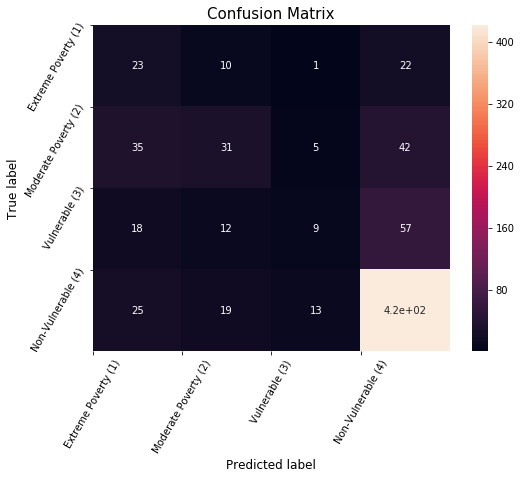

In [183]:
plot_confusion_matrix(y_test, rf_weighted_pred)

So we can see that our model predicted much more of the extreme poverty class than it did the first time. We also notice that our f1-macro score actually improved when using the weights. That doesn't mean however that there aren't trade-offs. Most of the time our precision falls when we put more weight on a specific class. We also see that recall falls in some of the other classes. So it is necessary to decide what is most important to us, and tune our model accordingly.

## 6.2 Oversampling
<a id="smote"></a>
Oversampling is another technique that we can use to handle imbalanced data. Instead of manipulating our cost function to change the way our model learns the data, we can also show our model more examples of the under-represented classes so it does a better job of predicting those classes.  

We are going to use a random oversampler to oversample from the lower poverty classes until all of the classes have the same number of observations. We are going to do this using the [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) package. We will create new training data using this techinque and graph it to show that we have the same number of observations in each class.

In [33]:
#Create new training sets with resampled data
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

([<matplotlib.axis.XTick at 0x26908809b70>,
 <a list of 4 Text xticklabel objects>)

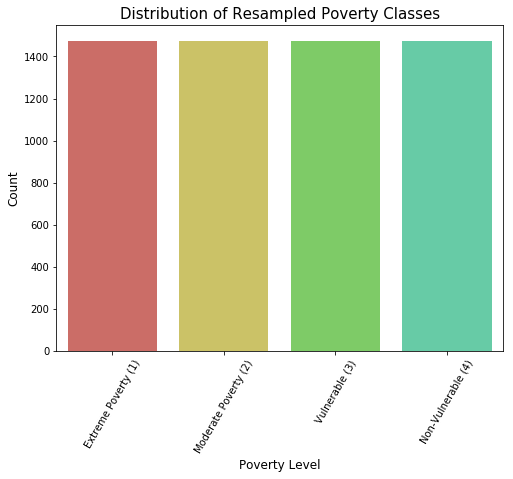

In [185]:
#Graph resampled data
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y_resampled)
plt.title('Distribution of Resampled Poverty Classes', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

Now we can see that we have close to 1500 observations in each class. We will train our original Random Forest model on the oversampled data and use it to predict the test data to see what kind of difference it makes.

In [190]:
print('----- ORIGINAL CLASSIFICATION REPORT -----\n')
print(rf_report)

rf_resampled = rf
rf_resampled.fit(x_resampled, y_resampled)
rf_resampled_pred = rf_resampled.predict(x_test)
rf_resampled_report = classification_report(y_test, rf_resampled_pred)
print('----- RESAMPLING CLASSIFICATION REPORT -----\n')
print(rf_resampled_report)

----- ORIGINAL CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.50      0.09      0.15        56
           2       0.40      0.19      0.25       113
           3       0.67      0.04      0.08        96
           4       0.70      0.99      0.82       479

   micro avg       0.67      0.67      0.67       744
   macro avg       0.57      0.33      0.33       744
weighted avg       0.63      0.67      0.59       744

----- RESAMPLING CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.23      0.25      0.24        56
           2       0.33      0.36      0.35       113
           3       0.23      0.26      0.24        96
           4       0.84      0.79      0.81       479

   micro avg       0.62      0.62      0.62       744
   macro avg       0.41      0.42      0.41       744
weighted avg       0.64      0.62      0.63       744



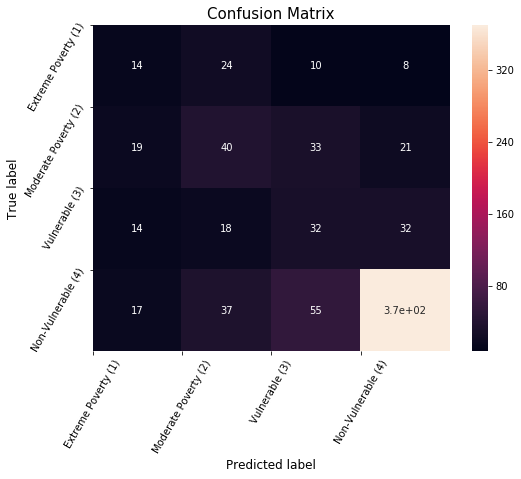

In [187]:
plot_confusion_matrix(y_test, rf_resampled_pred)

With our resampled training data, our model did a much better job at predicting the lowest poverty classes. But once again we see there is a trade-off between precision and recall. The precision of poverty classes 1-3 fell and the recall of the non-vulnerable class fell as precision rose. But in the context of our problem it is obviously more important to predict the people who are the most in need, not the ones who are well off. We can also note that the f1-macro score we were trying to maximize before actually went up to .44 now.

## 7. Understanding & Interpreting the Model
<a id="featimport"></a>
We have built a model that is more in harmony with the problem we are trying to solve. Now it is important to actually understand our model. We are going to look at what the most important features were for predicting poverty. This allows us to explain to others how our model is making the predictions that it does and more easily share work with those who do not understand the language of data.

In [73]:
#Feature importances
feature_importances = pd.DataFrame(columns = ['Variable', 'Coef'])
feature_importances['Variable'] = list(x)
feature_importances['Coef'] = abs(rf_resampled.feature_importances_)
feature_importances.sort_values(by = 'Coef', ascending = False, inplace = True)
feature_importances = feature_importances[0:15]

Text(0.5, 1.0, 'Most Important Features in Resampled Random Forest Model')

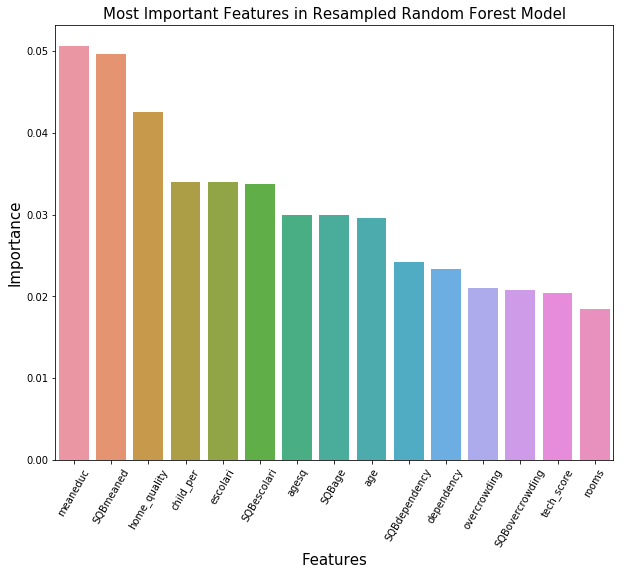

In [76]:
#Plot top 15 features
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances['Variable'], y = feature_importances['Coef'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.xticks(rotation = 60)
plt.title('Most Important Features in Resampled Random Forest Model', fontsize=15)

A few notes about the feature importances:
1. Because we are using a Random Forest, these may change slightly each time we run the model. But in general, the top ten remain the top ten for the most part. They may switch positions a little, but the important ones almost always stay important.    


2. You may notice that many of the variables that our model considers important are accompanied by the square of that same variable. This can be used sometimes to account for non-linear relationships. This may actually however, be causing our model to perform worse because of the collinearity between the two variables. In a real situation, we would want to remove them and see if our model improved.  


3. A few of the variables that we created in the feature engineering section of the notebook appear to have made an impact on our final model. This is great news! 

## 8. Conclusion
<a id="done"></a>
We cleaned our data, engineered new features, built a model, dealt with unbalanced data, and interpreted our model. It is important to always keep in mind the question we are answering every time we build a model. It may be possible to build a model that appears good by one metric, but doesn't actually answer the question we want. In this notebook, we focused on answering the important question and made the necessary tradeoffs to get the most practical model for the job.